In [1]:
import os
import ml_collections
import numpy as np
import cv2
import matlab.engine # the matlab engine for python
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

from wavebench.generate_data.time_varying.generate_data_is import generate_is
from wavebench import wavebench_dataset_path
from wavebench.generate_data.time_varying.gaussian_random_field import generate_gaussian_random_field
from wavebench.utils import absolute_file_paths, seed_everything

In [2]:
thick_lines_data_path = os.path.join(
    wavebench_dataset_path, "time_varying/thick_lines")

config = ml_collections
config.device_id = 0
config.save_data = False

config.domain_sidelen = 512
config.domain_dx = 2

# config.medium_type = 'gaussian_lens' # 'gaussian_random_field'
config.medium_type = 'gaussian_random_field'

config.medium_source_loc = (199, 219)
config.medium_density = 2650
config.pml_size = 10

#  define the properties of the propagation medium
min_wavespeed = 1400
max_wavespeed = 4000
point_mass_strength = -31000

if config.medium_type == 'gaussian_lens':
    z = np.ones((config.domain_sidelen,config.domain_sidelen))
    z[config.medium_source_loc] = point_mass_strength
    medium_sound_speed = cv2.GaussianBlur(
        z,
        ksize=(0, 0),
        sigmaX=200,
        borderType=cv2.BORDER_REPLICATE)
elif config.medium_type == 'gaussian_random_field':
    seed_everything(42)
    medium_sound_speed = generate_gaussian_random_field(
        size = config.domain_sidelen,
        alpha=3.0)
else:
    raise NotImplementedError

medium_sound_speed -= medium_sound_speed.min()
medium_sound_speed /= medium_sound_speed.max()

config.medium_sound_speed = medium_sound_speed*(
max_wavespeed - min_wavespeed) + min_wavespeed

# only a single example is generated
config.source_list = sorted(absolute_file_paths(thick_lines_data_path))[:1]
initial_pressure_dataset, boundary_measurement_dataset = generate_is(config)
jwave_measurements = boundary_measurement_dataset[0]

Save data? False


100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


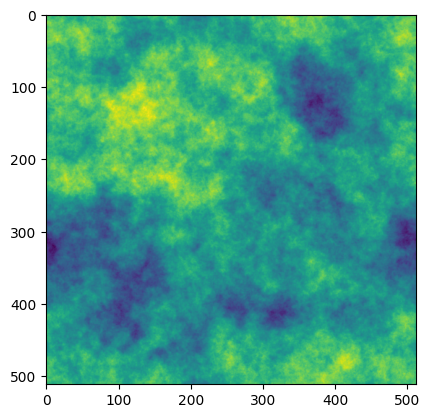

In [3]:
plt.imshow(config.medium_sound_speed)

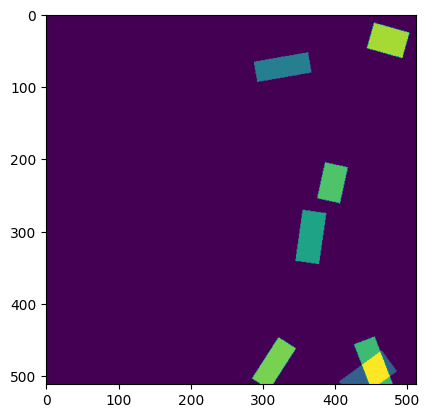

In [4]:
plt.imshow(initial_pressure_dataset[0])

In [ ]:
eng = matlab.engine.start_matlab()


In [5]:
import jax
from wavebench import wavebench_path


resized_len = config.domain_sidelen//2

resized_initial_pressure = np.zeros_like(initial_pressure_dataset[0])

# resized_initial_pressure = initial_pressure_dataset[0]
image_array = jax.image.resize(
  initial_pressure_dataset[0],
  (resized_len, resized_len),
  method='bicubic')

resized_initial_pressure[
    :resized_len,
    resized_len//2: resized_len//2 + resized_len] = image_array


eng = matlab.engine.start_matlab()
eng.cd(str(os.path.join(wavebench_path, "wavebench/generate_data/test")))


kwave_measurements = eng.compute_is_measurements(
  np.double(config.medium_sound_speed),
  np.double(config.medium_density),
  np.double(config.domain_dx),
  resized_initial_pressure)
kwave_measurements = np.array(kwave_measurements)

Unrecognized function or variable 'compute_is_measurements'.



MatlabExecutionError: Undefined function 'compute_is_measurements' for input arguments of type 'double'.


In [ ]:
str(os.path.join(wavebench_path, "wavebench/generate_data/test"))

'/home/liu0003/Desktop/projects/wavebench/wavebench/generate_data/test'

In [ ]:
mse = np.mean( (kwave_final_pressure - jwave_final_pressure)**2 )
np.testing.assert_array_less(mse, 1e-4)


NameError: name 'jwave_final_pressure' is not defined

Text(0.5, 1.0, 'diff')

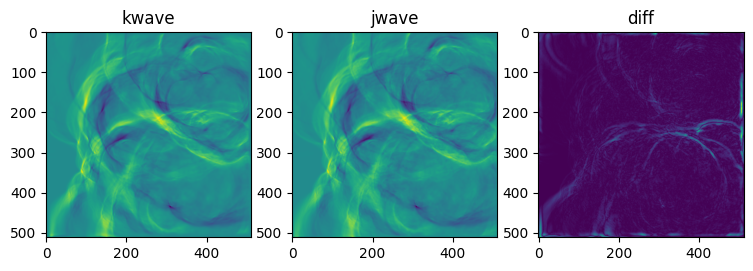

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(kwave_final_pressure)
axes[0].set_title('kwave')
axes[1].imshow(jwave_final_pressure)
axes[1].set_title('jwave')
axes[2].imshow(np.abs(jwave_final_pressure - kwave_final_pressure))
axes[2].set_title('diff')



In [ ]:
import os
wavebench_path = os.path.dirname(
  '/home/liu0003/Desktop/projects/wavebench/')


In [ ]:
str(os.path.join(wavebench_path, "generate_data/test"))

'/home/liu0003/Desktop/projects/wavebench/generate_data/test'